In [34]:
# use new database and processing methods

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)


['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/david/Documents/mastersCode/ubm/classifiers/hmm/development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm', '/Users/david/Documents/mastersCode/ubm']


In [35]:
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
from importlib import reload
from collections import Counter
import pickle
import time

Using cache found in /Users/david/.cache/torch/hub/snakers4_silero-vad_master


In [36]:
import data.pitch_tracking_database.load_data as load_data
reload(load_data)
speech_pitch_tracking_db = pickle.load(open(load_data.normalised_30,'rb'))
ads = speech_pitch_tracking_db['ads']

In [37]:
# split ads
developmentLabels = ["M03","M04","M05","M06","M07","M08","M09","M10","F05","F06","F07","F08","F09","F10",
                     "F03","F04"]
evaluationLabels = ["M01","M02","F01","F02"]
adsTrain = myads.subset(ads, developmentLabels)
adsEvaluate = myads.subset(ads, evaluationLabels)
numFilesPerSpeakerForEnrollment = 10
adsEnroll, adsDet = myads.split(adsEvaluate, numFilesPerSpeakerForEnrollment)
adsTest = adsDet
# adsDet, adsTest = myads.split(adsDet, 2)
adsTrain.info('Train')
adsEnroll.info('Enroll')
adsTest.info('Test')

Train database info: 
dict_keys(['F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'M03', 'M04', 'M05', 'M06', 'M07', 'M08', 'M09', 'M10'])
dict_values([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30])


Enroll database info: 
dict_keys(['F01', 'F02', 'M01', 'M02'])
dict_values([10, 10, 10, 10])


Test database info: 
dict_keys(['F01', 'F02', 'M01', 'M02'])
dict_values([20, 20, 20, 20])




In [38]:
from classifiers.classifier_base import ClassifierBase
from my_torch.tuts2.torch_transforms import ComposeTransform

def test_classifiers(ads_train, ads_test, classifiers: [ClassifierBase], verbose=False):
    index = 1
    if verbose:
        print('running all')

    for classifier in classifiers:
        if verbose:
            print('\n')
            print('test #', index)
        print(classifier.info)

        classifier.train(ads_train)
        classifier.test_all(ads_test)
        index = index + 1
        if verbose:
            print('\n')

In [39]:
import classifiers.gmm_ubm.classifier_gmm_ubm as classifier_gmm_ubm
reload(classifier_gmm_ubm)

import my_torch.tuts2.torch_transforms as torch_t
reload(torch_t)
from feature_extraction.fe_spafe.fe_spafe import FeatureExtractorMfcc

# define fe methods

fe_mfcc = FeatureExtractorMfcc()
fe_mfcc.set_normalisation(adsDet)


In [40]:
import classifiers.hmm.classifier_hmm as classifier_hmm
reload(classifier_hmm)

# define classifiers

classifier_a = classifier_hmm.ClassifierHMM(
    train_process=torch_t.ComposeTransform([
        torch_t.FeMethodCheck(),
        fe_mfcc
    ]),
    test_process=torch_t.ComposeTransform([
    torch_t.ProcessMethodCheck(),
    torch_t.AddGaussianWhiteNoise(15),
    torch_t.FeMethodCheck(),
    fe_mfcc,
    ]),
    info='base mfcc with 15 SNR DB'
)

classifier_b = classifier_hmm.ClassifierHMM(
    train_process=torch_t.ComposeTransform([
        torch_t.FeMethodCheck(),
        fe_mfcc
    ]),
    test_process=torch_t.ComposeTransform([
    torch_t.ProcessMethodCheck(),
    torch_t.AddGaussianWhiteNoise(10),
    torch_t.FeMethodCheck(),
    fe_mfcc,
    ]),
    info='base mfcc with 10 SNR DB'
)

classifier_c = classifier_hmm.ClassifierHMM(
    train_process=torch_t.ComposeTransform([
        torch_t.FeMethodCheck(),
        fe_mfcc
    ]),
    test_process=torch_t.ComposeTransform([
    torch_t.ProcessMethodCheck(),
    torch_t.AddGaussianWhiteNoise(5),
    torch_t.FeMethodCheck(),
    fe_mfcc,
    ]),
    info='base mfcc with 5 SNR DB'
)


running all


test # 1
base mfcc with 15 SNR DB


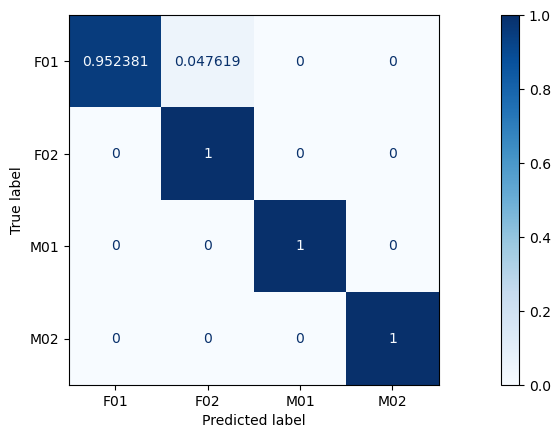





test # 2
base mfcc with 10 SNR DB


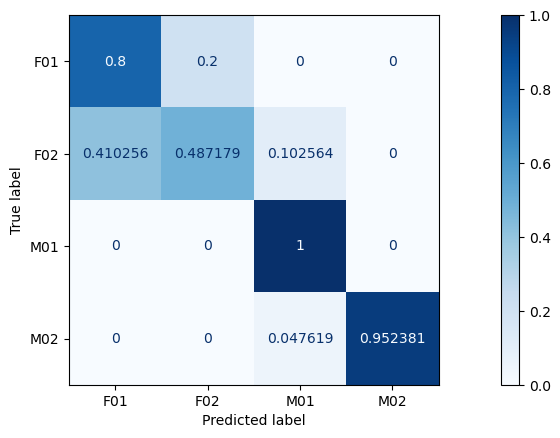





test # 3
base mfcc with 5 SNR DB


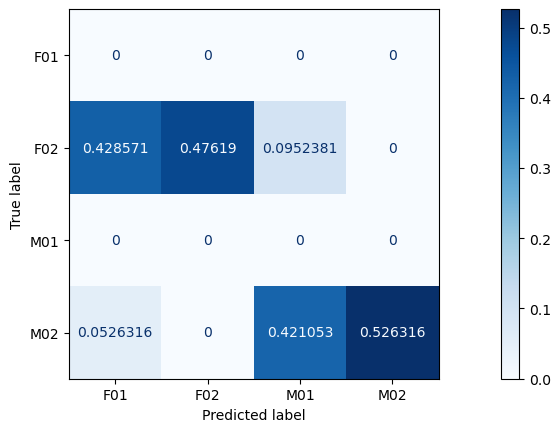

In [41]:
test_classifiers(adsEnroll, adsTest, [classifier_a, classifier_b, classifier_c], verbose=True)